#### Group Information

Group No: 

- Member 1: Lai Yicheng
- Member 2: Lee Ying Shen
- Member 3: Lim Ting Juin
- Member 4: Koay Chun Keat

#### Import Libraries

In [399]:
%config Completer.use_jedi=False

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

# Set a random seed for reproducible results 
tf.random.set_seed(42)

#### Load the dataset

In [400]:
dataset = pd.read_csv('classification_dataset.csv')
dataset.describe()

,f1,f2,f3,f4,f5,label
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,0.422609,0.608152,5.572301,0.665370,5.495197,0.50000
std,5.105038,6.983217,5.840074,6.439401,4.186770,0.50025
min,-16.877003,-18.725112,-16.255804,-13.320196,-5.700803,0.00000
25%,-3.073090,-4.289903,1.759988,-4.489635,2.668686,0.00000
50%,0.447864,0.967124,5.760596,-0.465704,5.558958,0.50000
75%,3.743536,5.657798,9.556160,5.528407,8.388997,1.00000
max,15.376673,17.904490,24.342184,20.199927,20.973491,1.00000


#### Define the loss function

In [401]:
def loss_fn(y_true, y_pred):
    """
    This function calculates the loss function
    """

    # Setting a minimum and maximum value to prevent log(0) and log(1)
    # epsilon = 1e-7
    # y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Binary Negative Log-Likelihood 
    epsilon = 1e-7
    return -tf.reduce_mean(y_true * tf.math.log(y_pred + epsilon) + (1 - y_true) * tf.math.log(1 - y_pred + epsilon))

#### Define function to perform prediction

In [402]:
def sigmoid(output):
    """ 
    This function calculates the sigmoid function.
    """
    return 1 / (1 + tf.exp(-output))

def relu(inputs):
    """ 
    This function calculates the ReLU function.
    """
    return tf.maximum(0.0   , inputs)

def forward(inputs, weights, biases):
    """ 
    This function calculates the forward pass (predicts the label).
    """
    activation = inputs
    num_layers = len(weights) - 1
    for i in range(num_layers):
        weighted_sum = tf.matmul(activation, weights[i]) + biases[i]
        activation = relu(weighted_sum)

    weighted_sum_output = tf.matmul(activation, weights[-1]) + biases[-1]
    prediction = sigmoid(weighted_sum_output)

    return prediction

#### Define function for model training
Display the training and validation loss values for each epoch of the training loop. The displayed value must be in 6 decimal places.<br>
Hint: <br>
Use `tf.GradientTape` to compute the gradients.

In [403]:
def train(inputs, targets, weights, biases, learning_rate):
    """ 
    This function performs the forward pass, computes the gradient and update the weights and biases.
    """
    with tf.GradientTape(persistent=True) as tape:
        outputs = forward(inputs, weights, biases)
        loss = loss_fn(targets, outputs)

    for i in range(len(weights)):
        weights_grad = tape.gradient(loss, weights[i])
        biases_grad = tape.gradient(loss, biases[i])
        # Update weights and biases
        weights[i].assign_sub(learning_rate * weights_grad)
        biases[i].assign_sub(learning_rate * biases_grad)

    # Delete the tape after using it
    del tape

    return weights, biases, loss

def fit(train_dataset, valid_dataset, weights, biases, learning_rate, epochs):
    """ 
    This function implements the training loop.
    """

    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        # Training loop
        for inputs_batch, targets_batch in train_dataset:
            weights, biases, loss = train(inputs_batch, targets_batch, weights, biases, learning_rate)
        train_losses.append(loss)

        # Validation loop
        for inputs_batch, targets_batch in valid_dataset:
            valid_outputs = forward(inputs_batch, weights, biases)
            valid_loss = loss_fn(targets_batch, valid_outputs)
        valid_losses.append(valid_loss)

        print(f"Epoch: {epoch}, Train Loss: {loss}, Validation Loss: {valid_loss}")

    return weights, biases, train_losses, valid_losses


#### Define the tensors to hold the weights and biases (create the model)
Hint: <br>
Use `tf.Variable` to create the tensors.<br>
Put the tensors in a list.

In [404]:
import numpy as np


features = dataset.iloc[:, :-1]  # All rows, all columns except the last
labels = dataset.iloc[:, -1]  # All rows, only the last column

# Convert the pandas DataFrame into a TensorFlow Dataset
dataset_tf = tf.data.Dataset.from_tensor_slices((features.values, labels.values))
np.random.seed(42)
input_size = 5  # 5 features
hidden_size = 5  # Size of the hidden layer
output_size = 1  # Predict 2 classes

# Initialize weights and biases for each layer in lists
weights = [tf.Variable(np.random.randn(input_size, hidden_size)),
           tf.Variable(np.random.randn(hidden_size, output_size))]

biases = [tf.Variable(np.random.randn(1,hidden_size)),
          tf.Variable(np.random.randn(output_size))]

learning_rate = 0.01

#### Split the dataset
The ratio of training and test is 7:1:2.

In [405]:
# Shuffle the dataset
dataset_tf = dataset_tf.shuffle(buffer_size=len(dataset_tf), seed=42)

# Calculate the number of examples
total_size = len(dataset_tf)
train_size = int(0.7 * total_size)
valid_size = int(0.1 * total_size)
# The rest is used for testing

# Create the training, validation and test sets
train_dataset = dataset_tf.take(train_size)
valid_dataset = dataset_tf.skip(train_size).take(valid_size)
test_dataset = dataset_tf.skip(train_size + valid_size)

train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(5,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

#### Normalize the data

In [406]:
# Define a function to normalize the data
def normalize_data(features, labels):
    features = tf.cast(features, tf.float64)
    features = (features - tf.reduce_mean(features)) / tf.math.reduce_std(features)
    return features, labels

# Apply the normalization function to the datasets
train_dataset = train_dataset.map(normalize_data)
valid_dataset = valid_dataset.map(normalize_data)
test_dataset = test_dataset.map(normalize_data)


train_dataset = train_dataset.batch(batch_size=32, drop_remainder=True)
valid_dataset = valid_dataset.batch(batch_size=32, drop_remainder=True)

train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(32, 5), dtype=tf.float64, name=None), TensorSpec(shape=(32,), dtype=tf.int64, name=None))>

#### Train the model

In [407]:
# Train the model
weights, biases, train_losses, valid_losses = fit(train_dataset, valid_dataset, weights, biases, learning_rate, 30)

Epoch: 0, Train Loss: 1.4268534183502197, Validation Loss: 1.4228986501693726
Epoch: 1, Train Loss: 1.103428602218628, Validation Loss: 1.1289706230163574
Epoch: 2, Train Loss: 0.8508901000022888, Validation Loss: 0.7790223956108093
Epoch: 3, Train Loss: 0.8675691485404968, Validation Loss: 0.8540824055671692
Epoch: 4, Train Loss: 0.746639609336853, Validation Loss: 0.8865107297897339
Epoch: 5, Train Loss: 0.7765456438064575, Validation Loss: 0.7790642976760864
Epoch: 6, Train Loss: 0.7667906284332275, Validation Loss: 0.7554401755332947
Epoch: 7, Train Loss: 0.7125152349472046, Validation Loss: 0.866689920425415
Epoch: 8, Train Loss: 0.7683587074279785, Validation Loss: 0.7471915483474731
Epoch: 9, Train Loss: 0.7912497520446777, Validation Loss: 0.7633844614028931
Epoch: 10, Train Loss: 0.7290899753570557, Validation Loss: 0.7504293918609619
Epoch: 11, Train Loss: 0.7348073720932007, Validation Loss: 0.7693778276443481
Epoch: 12, Train Loss: 0.7363801002502441, Validation Loss: 0.716

#### Display the training loss and validation loss against epoch graph

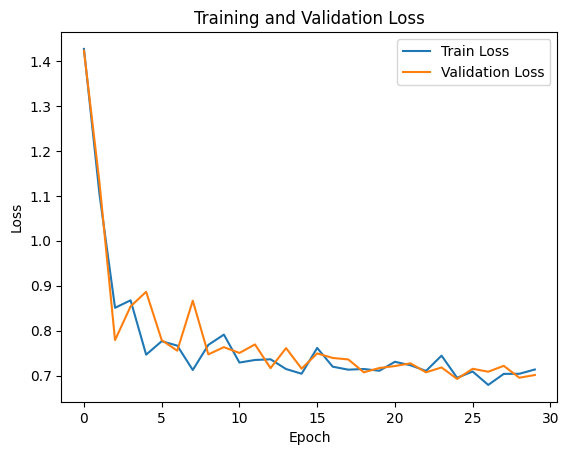

In [408]:
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Predict the test set

#### Display the confusion matrix and the classification report.